# Multi Agent

In [56]:
# Install required packages if not already installed
!pip install --upgrade langchain langgraph langchain-openai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.4/438.4 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.50
    Uninstalling langcha

In [57]:
import os
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END
from typing import TypedDict
import re
from langchain_openai import ChatOpenAI

In [58]:
# The  API Key
os.environ['OPENROUTER_API_KEY'] = "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"  # <-- Replace with your key

In [59]:
# State
class MedicalState(TypedDict):
    disease: str
    country: str
    disease_info: str
    hospital_list: str

In [60]:
# Memory
class AgentMemory:
    def __init__(self):
        self.chat_log = []
    
    def update(self, message: str):
        self.chat_log.append(message)
    
    def get_context(self, n=5):
        return "\n".join(self.chat_log[-n:])

memory = AgentMemory()

In [61]:
# LLM initialization
def get_llm(model: str = "gpt-3.5-turbo", temp: float = 0.2):
    return ChatOpenAI(
        openai_api_key=os.environ['OPENROUTER_API_KEY'],
        openai_api_base="https://openrouter.ai/api/v1",
        model=model,
        temperature=temp,
        max_retries=3,
        timeout=30
    )

In [66]:
# Agent 1: Disease Info Agent
def disease_info_agent(state: MedicalState) -> MedicalState:
    prompt = f"""You are a helpful medical assistant.
Provide a clear and concise 4–5 sentence description of the skin disease "{state['disease']}" and after that only mention the following briefly in this format: 
1- its symptoms: 
2- its causes:
3- the possible treatments:.

Disease: {state['disease']}
Description:"""

    llm = get_llm("gpt-3.5-turbo", 0.2)
    response = llm.invoke([
        SystemMessage(content="You are a reliable, medically informed assistant."),
        HumanMessage(content=prompt)
    ]).content
    
    memory.update(f"Disease Info: {response}")
    return {**state, "disease_info": response}

In [67]:
# Agent 2: Hospital Finder Agent
def hospital_finder_agent(state: MedicalState) -> MedicalState:
    prompt = f"""List 5 well-known hospitals or dermatology clinics in {state['country']} where someone can go for treatment of a skin disease.
Include their:
- name
- city
- contact number (if possible)
- a short address

Only show relevant institutions with a reputation for dermatology or skin care."""

    llm = get_llm("gpt-3.5-turbo", 0.2)
    response = llm.invoke([
        SystemMessage(content="You are a medical travel assistant helping people find hospitals."),
        HumanMessage(content=prompt)
    ]).content
    
    memory.update(f"Hospital Info: {response}")
    return {**state, "hospital_list": response}

In [68]:
# Building the Graph
def build_workflow():
    graph = StateGraph(MedicalState)
    graph.add_node("describe_disease", disease_info_agent)
    graph.add_node("find_hospitals", hospital_finder_agent)
    graph.set_entry_point("describe_disease")
    graph.add_edge("describe_disease", "find_hospitals")
    graph.add_edge("find_hospitals", END)
    return graph.compile()

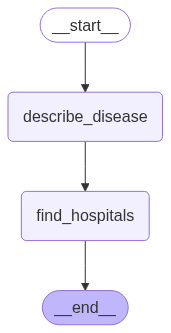

In [69]:
build_workflow()

In [70]:
# The Main Function
def medical_assistant(disease: str, country: str):
    initial_state = {
        "disease": disease.strip(),
        "country": country.strip(),
        "disease_info": "",
        "hospital_list": ""
    }
    
    try:
        assistant = build_workflow()
        final_state = assistant.invoke(initial_state)

        output = f"""
==============================
Information About: {final_state['disease']}
==============================
{final_state['disease_info']}

==============================
Hospitals in {final_state['country']}
==============================
{final_state['hospital_list']}
"""
        return output

    except Exception as e:
        return f"An error occurred: {str(e)}"

# Test Cases

In [72]:
# Actinic_keratosis & Egypt
if __name__ == "__main__":
    disease = "Actinic_keratosis"
    country = input("Enter your country to find hospitals: ")

    print("\nRunning Medical Assistant...\n")
    result = medical_assistant(disease, country)
    print(result)


Enter your country to find hospitals:  Egypt



Running Medical Assistant...


Information About: Actinic_keratosis
Actinic keratosis is a common precancerous skin condition caused by long-term sun exposure. It appears as rough, scaly patches on sun-exposed areas such as the face, scalp, ears, and hands. Actinic keratosis can progress to skin cancer if left untreated, so it is important to monitor and manage these lesions promptly. Treatment options include topical medications, cryotherapy (freezing), chemical peels, and photodynamic therapy.

Symptoms:
- Rough, scaly patches on sun-exposed skin
- Itching or burning sensation in the affected areas

Causes:
- Prolonged exposure to ultraviolet (UV) radiation from the sun
- Fair skin, light hair, and blue or green eyes increase the risk
- Age and a history of frequent sunburns also contribute to the development of actinic keratosis

Possible treatments:
- Topical medications such as fluorouracil, imiquimod, or diclofenac
- Cryotherapy (freezing) to destroy the abnormal skin cells
- Ch

In [73]:
# Basal_cell_carcinoma & America
if __name__ == "__main__":
    disease = "Basal_cell_carcinoma"
    country = input("Enter your country to find hospitals: ")

    print("\nRunning Medical Assistant...\n")
    result = medical_assistant(disease, country)
    print(result)

Enter your country to find hospitals:  America



Running Medical Assistant...


Information About: Basal_cell_carcinoma
Basal cell carcinoma is the most common type of skin cancer that arises from the basal cells in the outermost layer of the skin. It typically appears as a pearly or waxy bump, with visible blood vessels, or as a flat, flesh-colored or brown scar-like lesion. This type of skin cancer is usually slow-growing and rarely spreads to other parts of the body, but it can be locally invasive and cause disfigurement if left untreated.

1- Symptoms: Pearly or waxy bump, flat flesh-colored or brown scar-like lesion, visible blood vessels.
2- Causes: Prolonged exposure to ultraviolet (UV) radiation from the sun, tanning beds, or other sources.
3- Treatments: Surgical excision, Mohs surgery, cryotherapy, topical medications, radiation therapy.

Hospitals in America
1. Mayo Clinic
   - City: Rochester, Minnesota
   - Contact Number: 507-284-2511
   - Address: 200 1st St SW, Rochester, MN 55905

2. Cleveland Clinic
   - City: Clev

In [74]:
# Benign_keratosis & Egypt
if __name__ == "__main__":
    disease = "Benign_keratosis"
    country = input("Enter your country to find hospitals: ")

    print("\nRunning Medical Assistant...\n")
    result = medical_assistant(disease, country)
    print(result)

Enter your country to find hospitals:  Egypt



Running Medical Assistant...


Information About: Benign_keratosis
Benign keratosis, also known as seborrheic keratosis, is a common non-cancerous skin growth that appears as a waxy, stuck-on lesion with a rough or scaly surface. These growths are typically brown, black, or tan in color and can vary in size. They are more common in older adults and are usually found on the face, chest, back, or shoulders.

1- Symptoms: Benign keratosis presents as raised, wart-like growths on the skin that are usually painless and do not itch.
2- Causes: The exact cause of benign keratosis is unknown, but factors such as genetics, sun exposure, and age may play a role in its development.
3- Treatments: Benign keratosis does not require treatment unless it becomes bothersome or cosmetically undesirable. Options for removal include cryotherapy, curettage, laser therapy, or surgical excision.

Hospitals in Egypt
1. Dar Al Fouad Hospital
   - City: Cairo
   - Contact Number: +20 2 26176000
   - Address: R

In [75]:
# Dermatofibroma & England
if __name__ == "__main__":
    disease = "Dermatofibroma"
    country = input("Enter your country to find hospitals: ")

    print("\nRunning Medical Assistant...\n")
    result = medical_assistant(disease, country)
    print(result)

Enter your country to find hospitals:  England



Running Medical Assistant...


Information About: Dermatofibroma
Dermatofibroma is a common benign skin growth that typically presents as a firm, raised nodule on the skin, most commonly found on the lower extremities. It is usually painless and may have a reddish-brown color. Dermatofibromas are often asymptomatic but can sometimes be itchy or tender to the touch. They are typically harmless and do not require treatment unless they become bothersome or cosmetically undesirable.

Symptoms:
- Firm, raised nodule on the skin
- Reddish-brown color
- May be itchy or tender

Causes:
- The exact cause is unknown, but dermatofibromas may develop in response to minor skin trauma or insect bites

Possible treatments:
- Observation: Often no treatment is necessary as dermatofibromas are usually harmless
- Surgical excision: If the growth is bothersome or for cosmetic reasons
- Cryotherapy: Freezing the growth off with liquid nitrogen

Hospitals in England
1. St John's Institute of Dermatology
C

In [76]:
# Melanocytic_nevus & France
if __name__ == "__main__":
    disease = "Melanocytic_nevus"
    country = input("Enter your country to find hospitals: ")

    print("\nRunning Medical Assistant...\n")
    result = medical_assistant(disease, country)
    print(result)

Enter your country to find hospitals:  France



Running Medical Assistant...


Information About: Melanocytic_nevus
Melanocytic nevus, commonly known as a mole, is a benign skin lesion that results from the clustering of melanocytes, the cells responsible for skin pigmentation. These moles can vary in color, size, and shape, and are usually round or oval with well-defined borders. While most moles are harmless, some may exhibit atypical features that warrant further evaluation by a dermatologist to rule out skin cancer.

1- Symptoms: Typically, melanocytic nevi appear as small, dark spots on the skin, ranging from light brown to black in color. They may be flat or raised, and can develop anywhere on the body.
2- Causes: The exact cause of melanocytic nevi is not fully understood, but they are thought to be influenced by genetic factors and sun exposure. Individuals with fair skin and a history of sunburns are more prone to developing moles.
3- Treatments: In most cases, no treatment is necessary for melanocytic nevi. However, if a 

In [77]:
# Melanoma & Germany
if __name__ == "__main__":
    disease = "Melanoma"
    country = input("Enter your country to find hospitals: ")

    print("\nRunning Medical Assistant...\n")
    result = medical_assistant(disease, country)
    print(result)

Enter your country to find hospitals:  Germany



Running Medical Assistant...


Information About: Melanoma
Melanoma is a type of skin cancer that originates in the pigment-producing cells of the skin called melanocytes. It is considered the most serious form of skin cancer due to its ability to spread quickly to other parts of the body. Melanoma is often characterized by changes in the size, shape, or color of existing moles, or the development of new pigmented or unusual-looking growths on the skin.

1- Symptoms: Changes in the size, shape, or color of moles, development of new pigmented growths, itching, bleeding, or ulceration of existing moles.
2- Causes: Exposure to ultraviolet (UV) radiation from the sun or tanning beds, genetic factors, a history of sunburns, and having fair skin, light eyes, or a large number of moles.
3- Treatments: Surgical removal of the melanoma and surrounding tissue, chemotherapy, radiation therapy, immunotherapy, targeted therapy, and clinical trials for advanced cases.

Hospitals in Germany
1. Chari

In [78]:
# Squamous_cell_carcinoma & Egypt
if __name__ == "__main__":
    disease = "Squamous_cell_carcinoma"
    country = input("Enter your country to find hospitals: ")

    print("\nRunning Medical Assistant...\n")
    result = medical_assistant(disease, country)
    print(result)

Enter your country to find hospitals:  Egypt



Running Medical Assistant...


Information About: Squamous_cell_carcinoma
Squamous cell carcinoma is a type of skin cancer that arises from the squamous cells in the outer layer of the skin. It is usually caused by prolonged exposure to ultraviolet (UV) radiation from the sun or tanning beds. This type of skin cancer can appear as a firm, red nodule, a flat sore with a scaly crust, or a new growth or sore that doesn't heal.

1- Symptoms: Firm, red nodules, flat sores with scaly crust, non-healing sores.
2- Causes: Prolonged exposure to UV radiation from the sun or tanning beds.
3- Treatments: Surgical excision, Mohs surgery, radiation therapy, topical medications.

Hospitals in Egypt
1. Cairo University Hospitals - Kasr Al Ainy
City: Cairo
Contact Number: +20 2 23640451
Address: Kasr Al Ainy St., El-Manial, Cairo, Egypt

2. Dar Al Fouad Hospital
City: Giza
Contact Number: +20 2 37481000
Address: 6th of October City, Giza, Egypt

3. Ain Shams University Hospitals
City: Cairo
Contact Nu

In [79]:
# Vascular_lesion & America
if __name__ == "__main__":
    disease = "Vascular_lesion"
    country = input("Enter your country to find hospitals: ")

    print("\nRunning Medical Assistant...\n")
    result = medical_assistant(disease, country)
    print(result)

Enter your country to find hospitals:  America



Running Medical Assistant...


Information About: Vascular_lesion
Vascular lesions are abnormalities in blood vessels that can appear on the skin. These lesions can manifest as red or purple discolorations, often in the form of birthmarks, hemangiomas, or port-wine stains. They are typically benign but can sometimes cause cosmetic concerns or, in rare cases, lead to complications. Vascular lesions are commonly seen in infants and young children but can also develop in adults.

Symptoms:
- Red or purple discolorations on the skin
- Raised or flat marks on the skin
- May be present at birth or develop later in life

Causes:
- Genetics
- Hormonal changes
- Trauma or injury to blood vessels
- Unknown factors in some cases

Possible treatments:
- Laser therapy
- Surgical removal
- Medications to help reduce the appearance
- Observation in cases where the lesion is not causing any issues

Hospitals in America
1. Mayo Clinic
   - City: Rochester, Minnesota
   - Contact Number: 507-284-2511
 